# 2) Data Analysis - US Hit Streaming Songs Project

__The following Jupyter Notebook analyzes the data collected in the previous section of this project__. The analysis will be split into the following sections:
- Imports
- Data Distribution Analysis
- Variable Correlation Analysis
- Analysis of Song Length
- Largest album eras of the streaming era on the Top 50
- Largest artists of the streaming era on the Top 50
- Dashboard of week-to-week changes in music qualities
    - ___For some reason, the interactive plotly dashboard at the end of this Notebook doesn't show up when uploading to GitHub. Please view [the other version of this Jupyter Notebook to see the full dashboard](https://tinyurl.com/WeeklyTrendsStreamingHits)!___

__Overview:__  As every data scientist/machine learning engineer should do before creating and testing a model, I extensively analyzed the data at hand. First, I analyzed the data distribution for each numerical variable. From here, several conclusions were made (such as the facts that most top 50 songs tend to lack instrumentalness and acousticness, possess higher levels of danceability and energy, have an average length of around 3 minutes and 20 seconds, and more). Then, I viewed the variables' correlation with each other (which helped determine what variables to use in my models). After that, I made various graphs of total streams versus song lengths and concluded that popular songs don't necessarily have shorter song lengths. Finally, I created a dashboard of the week-to-week changes in average song characteristics for all weekly charts since 2017. To do so, I normalized all variables that were not on a 0-1 scale, converted my data table from a wide format to a long format (from each observation being a song to now being the individual weekly streams for a song), grouped and averaged my data for each week, and used Plotly to create the dashboard. The dashboard provides numerous conclusions about popular music, and several key highlights include the following: acoustic-oriented music has been slowly rising since its low point in 2018 (when rap/trap music dominated the charts), speechiness levels slightly lowered since the pandemic started thanks to the increasing popularity of non-rap pop music on the streaming charts (also likely due to TikTok becoming the primary platform for emerging music trends as opposed to SoundCloud which is more associated with rap), superstar artists (such as Adele, Drake, and Taylor Swift) can afford to release albums with songs that have longer-than-usual song lengths and still achieve massive success, and more!


# Imports
To start, we import necessary tools and the data collected previously. 

In [1]:
#for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to remove the limits on a dataframe's columns displayed
pd.set_option('display.max_columns', None)

#to access google sheets with python
import gspread
from google.oauth2 import service_account
from oauth2client.service_account import ServiceAccountCredentials

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#for plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.express as px
import cufflinks as cf

# For Notebooks (plotly)
init_notebook_mode(connected=True)

# For offline use (plotly)
cf.go_offline()

In [2]:
#service account
sa = gspread.service_account(filename="gspread_service_account.json")

#sheet
sh = sa.open("HITS Streaming Songs")

#worksheet
wks = sh.worksheet("DF to Gspread")

#uses all values in the worksheet for the data frame
gsheets_df_updated = pd.DataFrame(wks.get_all_values())

header = gsheets_df_updated.iloc[0] #isolate first row as header
gsheets_df_updated = gsheets_df_updated[1:] #get rid of header in original df
gsheets_df_updated.columns = header

#set 'index' as index
gsheets_df_updated = gsheets_df_updated.set_index('index')

#convert index from string to int
gsheets_df_updated.index = gsheets_df_updated.index.astype(int)

#fill in blank values with 0 
gsheets_df_updated = gsheets_df_updated.replace(r'^\s*$', "0", regex=True)
    
#turn peak_date strings to date format
gsheets_df_updated['peak_date'] = pd.to_datetime(gsheets_df_updated['peak_date'])
gsheets_df_updated['release_date'] = pd.to_datetime(gsheets_df_updated['release_date'])

#change the following columns to int/float/boolean format
gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'] = gsheets_df_updated.loc[:,'streams_2017_to_present':'holiday_music'].astype(int)
gsheets_df_updated.loc[:,'length':'valence'] = gsheets_df_updated.loc[:,'length':'valence'].astype(float)
gsheets_df_updated['explicit'] = gsheets_df_updated['explicit'].apply(eval)

#drop christmas songs
gsheets_df_updated.drop(gsheets_df_updated[gsheets_df_updated['holiday_music']==1].index,inplace=True)
gsheets_df_updated.reset_index(drop=True, inplace=True)

gsheets_df_updated

,title,artist,album,peak_date,streams_2017_to_present,total_streams_2020s,peak_week_streams,current_year,2022-11-18,2022-11-11,2022-11-04,2022-10-28,2022-10-21,2022-10-14,2022-10-07,2022-09-30,2022-09-23,2022-09-16,2022-09-09,2022-09-02,2022-08-26,2022-08-19,2022-08-12,2022-08-05,2022-07-29,2022-07-22,2022-07-15,2022-07-08,2022-07-01,2022-06-24,2022-06-17,2022-06-10,2022-06-03,2022-05-27,2022-05-20,2022-05-13,2022-05-06,2022-04-29,2022-04-22,2022-04-15,2022-04-08,2022-04-01,2022-03-25,2022-03-18,2022-03-11,2022-03-04,2022-02-25,2022-02-18,2022-02-11,2022-02-04,2022-01-28,2022-01-21,2022-01-14,2022-01-07,2021-12-31,2021-12-24,2021-12-17,2021-12-10,2021-12-03,2021-11-26,2021-11-19,2021-11-12,2021-11-05,2021-10-29,2021-10-22,2021-10-15,2021-10-08,2021-10-01,2021-09-24,2021-09-17,2021-09-10,2021-09-03,2021-08-27,2021-08-20,2021-08-13,2021-08-06,2021-07-30,2021-07-23,2021-07-16,2021-07-09,2021-07-02,2021-06-25,2021-06-18,2021-06-11,2021-06-04,2021-05-28,2021-05-21,2021-05-14,2021-05-07,2021-04-30,2021-04-23,2021-04-16,2021-04-09,2021-04-02,2021-03-26,2021-03-19,2021-03-12,2021-03-05,2021-02-26,2021-02-19,2021-02-12,2021-02-05,2021-01-29,2021-01-22,2021-01-15,2021-01-08,2021-01-01,2020-12-25,2020-12-18,2020-12-11,2020-12-04,2020-11-27,2020-11-20,2020-11-13,2020-11-06,2020-10-30,2020-10-23,2020-10-16,2020-10-09,2020-10-02,2020-09-25,2020-09-18,2020-09-11,2020-09-04,2020-08-28,2020-08-21,2020-08-14,2020-08-07,2020-07-31,2020-07-24,2020-07-17,2020-07-10,2020-07-03,2020-06-26,2020-06-19,2020-06-12,2020-06-05,2020-05-29,2020-05-22,2020-05-15,2020-05-08,2020-05-01,2020-04-24,2020-04-17,2020-04-10,2020-04-03,2020-03-27,2020-03-20,2020-03-13,2020-03-06,2020-02-28,2020-02-21,2020-02-14,2020-02-07,2020-01-31,2020-01-24,2020-01-17,2020-01-10,2020-01-03,2019-12-27,2019-12-20,2019-12-13,2019-12-06,2019-11-29,2019-11-22,2019-11-15,2019-11-08,2019-11-01,2019-10-25,2019-10-18,2019-10-11,2019-10-04,2019-09-27,2019-09-20,2019-09-13,2019-09-06,2019-08-30,2019-08-23,2019-08-16,2019-08-09,2019-08-02,2019-07-26,2019-07-19,2019-07-12,2019-07-05,2019-06-28,2019-06-21,2019-06-14,2019-06-07,2019-05-31,2019-05-24,2019-05-17,2019-05-10,2019-05-03,2019-04-26,2019-04-19,2019-04-12,2019-04-05,2019-03-29,2019-03-22,2019-03-15,2019-03-08,2019-03-01,2019-02-22,2019-02-15,2019-02-08,2019-02-01,2019-01-25,2019-01-18,2019-01-11,2019-01-04,2018-12-28,2018-12-21,2018-12-14,2018-12-07,2018-11-30,2018-11-23,2018-11-16,2018-11-09,2018-11-02,2018-10-26,2018-10-19,2018-10-12,2018-10-05,2018-09-28,2018-09-21,2018-09-14,2018-09-07,2018-08-31,2018-08-24,2018-08-17,2018-08-10,2018-08-03,2018-07-27,2018-07-20,2018-07-13,2018-07-06,2018-06-29,2018-06-22,2018-06-15,2018-06-08,2018-06-01,2018-05-25,2018-05-18,2018-05-11,2018-05-04,2018-04-27,2018-04-20,2018-04-13,2018-04-06,2018-03-30,2018-03-23,2018-03-16,2018-03-09,2018-03-02,2018-02-23,2018-02-16,2018-02-09,2018-02-02,2018-01-26,2018-01-19,2018-01-12,2018-01-05,2017-12-29,2017-12-15,2017-12-08,2017-12-01,2017-11-24,2017-11-17,2017-11-10,2017-11-03,2017-10-27,2017-10-20,2017-10-13,2017-10-06,2017-09-29,2017-09-22,2017-09-15,2017-09-08,2017-09-01,2017-08-25,2017-08-18,2017-08-11,2017-08-04,2017-07-28,2017-07-21,2017-07-14,2017-07-07,2017-06-30,2017-06-23,2017-06-16,2017-06-09,2017-06-02,2017-05-26,2017-05-19,2017-05-12,2017-05-05,2017-04-28,2017-04-21,2017-04-14,2017-04-07,2017-03-31,total_2022,total_2021,total_2020,total_2019,total_2018,total_2017,units,holiday_music,remix_version,playlist_index,uri,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,explicit
0,Closer,The Chainsmokers,Closer,2016-09-09,10948414,0,5528407,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Data distrubution
Based on the following histographs taken from HITS and Spotify, _the following can be concluded_:
 
* A very __small amount of songs reach high popularity levels__ (based on the distributions of streams_2017_to_present and total_streams_2020s)
* Many songs on the top 50 __tend to peak with at a bit less than 10 million weekly streams__
* The __mean length__ of hit songs in the top 50 of streaming are at __around 200,000 milliseconds (or around 3 minutes, 20 seconds)__
* Most top 50 hit songs on streaming __lack acousticness__
* Most top 50 hit songs on streaming lean towards being __more danceable__ than not
* Most top 50 hit songs on streaming lean towards being __more energetic__
* An extremely high amount of songs __lack instrumentalness__
* Most top 50 hit songs on streaming lean towards being __less likely to be recorded with a live audience__
* Hit songs lean to be __more louder__
* The split between songs written in a major key (mode=1) versus a minor key (mode=0) leans __more__ towards __songs written in major key__
* Many songs __lack speechiness__ (_surprising given the prevalence of rap during the streaming era, but this could also make sense because of the rise of emo/melodic rap since 2017_)
* Distribution of __tempos are all over the place__
* The mean valence (musical positiveness conveyed by a track) for all songs leans more towards __sounding slightly more negative (sad, depressed, angry) than happy__

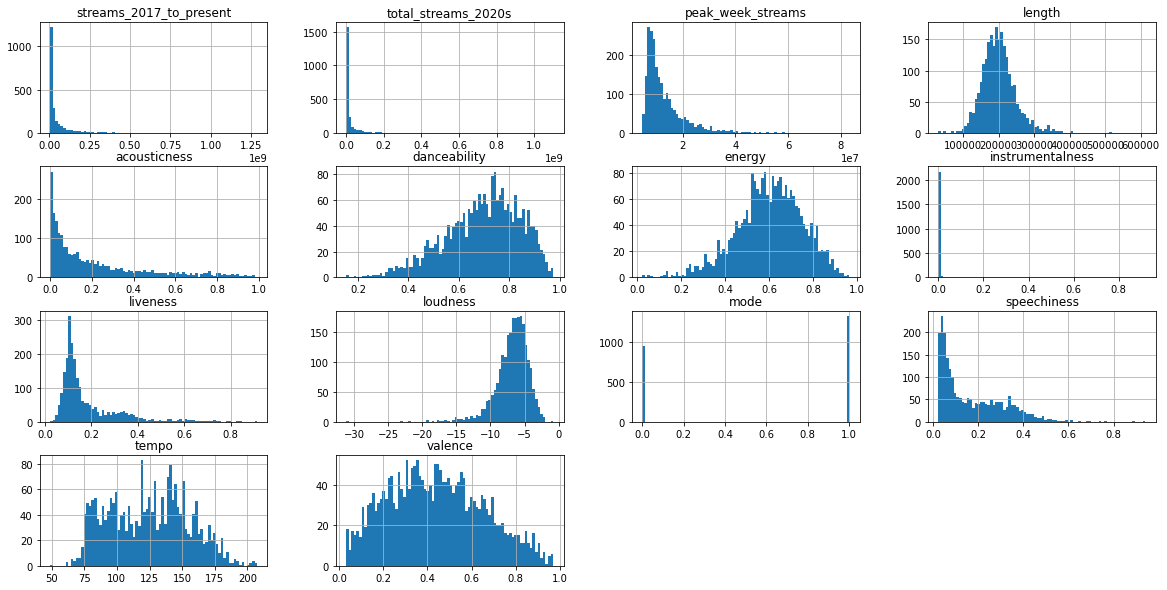

In [3]:
gsheets_df_updated[['streams_2017_to_present','total_streams_2020s'
          ,'peak_week_streams','length','acousticness'
         ,'danceability','energy','instrumentalness','liveness'
         ,'loudness','mode','speechiness','tempo'
          ,'valence']].hist(figsize=(20,10), bins=80)

plt.show()

In [4]:
gsheets_df_updated[['streams_2017_to_present','total_streams_2020s'
          ,'peak_week_streams','length','acousticness'
         ,'danceability','energy','instrumentalness','liveness'
         ,'loudness','mode','speechiness','tempo'
          ,'valence']].describe()

,streams_2017_to_present,total_streams_2020s,peak_week_streams,length,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
count,2.272000e+03,2.272000e+03,2.272000e+03,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000
mean,6.424931e+07,3.335691e+07,1.343808e+07,201410.948063,0.218012,0.694974,0.601272,0.008817,0.179832,-6.804526,0.584067,0.170528,124.219251,0.439839
std,1.165861e+08,8.622144e+07,8.377943e+06,51328.901922,0.239463,0.146692,0.148864,0.063228,0.129542,2.394029,0.492991,0.137414,30.234390,0.213949
min,4.715634e+06,0.000000e+00,4.715634e+06,30582.000000,0.000070,0.153000,0.021800,0.000000,0.021500,-31.160000,0.000000,0.023200,48.718000,0.032000
25%,8.980363e+06,0.000000e+00,8.061820e+06,169920.000000,0.036300,0.599000,0.513000,0.000000,0.103000,-7.945750,0.000000,0.053475,97.990500,0.272750
50%,1.751894e+07,7.569933e+06,1.060373e+07,196753.000000,0.124500,0.712000,0.609000,0.000000,0.128000,-6.475000,1.000000,0.119000,125.048000,0.432000
75%,6.040084e+07,2.055493e+07,1.570404e+07,225400.750000,0.316250,0.804000,0.705000,0.000012,0.211000,-5.234750,1.000000,0.271000,146.044500,0.592250
max,1.286717e+09,1.100315e+09,8.319680e+07,613026.000000,0.991000,0.974000,0.965000,0.918000,0.914000,-0.804000,1.000000,0.941000,207.476000,0.970000


# Correlation Graph

Based on the graph below, it seems like __only energy and loudness have a strong (below negative 0.67 or above positive 0.67) correlation with each other__.

Text(0.5, 1.0, 'Correlation Graph')

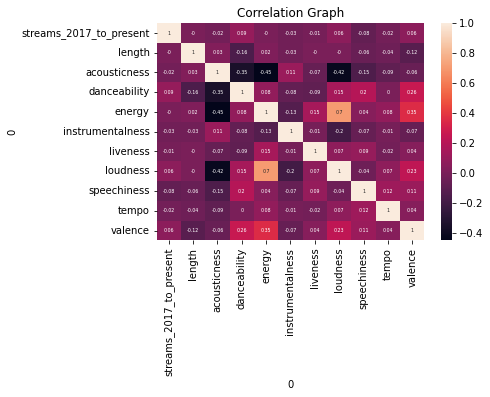

In [5]:
sns.heatmap(gsheets_df_updated.loc[:,['title','artist','album','streams_2017_to_present',
    'length','acousticness','danceability','energy','instrumentalness',
    'liveness','loudness','speechiness','tempo','valence']].corr().round(2),
           annot=True,
           annot_kws={'size': 4.8},
           xticklabels=True, 
           yticklabels=True)
plt.title('Correlation Graph')

# Analysis of Song Length

Prior scholarly research concludes that hit songs are shorter than they were in the past. __The following analyzes whether there are any changes in the mean and median length of a hit song as a song has more streams__. Based on the __visual analysis__ below, __more streams does not necessarily mean shorter song length__. 

In [6]:
#function to convert song length from milliseconds to minutes : seconds : milliseconds format
def ms_to_time(ms):
    """
    Converts milliseconds to time in "minute:secconds:millisecond" format

    Parameters:
        milliseconds (str): the length of a song in milliseconds
    
    Returns
        song_length (str): the length of a song converted into min:sec:ms format 
    """
    millis = ms
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    
    #a string will be returned so add 0 before songs with length < 10 mins so that songs above 10 mins won't be misordered when ordering by min:sec:ms format
    if minutes < 10:
        return "0%d:%d:%d" % (minutes, seconds, millis)
    else:
        return "%d:%d:%d" % (minutes, seconds, millis)

The average length of a hit song on the Streaming Top 50 (excluding holiday music) is:  03:21:201411
The median length of a hit song on the Streaming Top 50 (excluding holiday music) is:  03:16:196753
2272 songs appeared on the HITS Streaming Chart since 2017


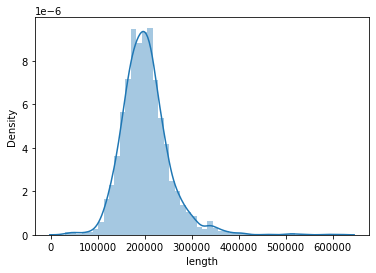

In [7]:
sns.distplot(gsheets_df_updated['length'])

print("The average length of a hit song on the Streaming Top 50 (excluding holiday music) is: ", ms_to_time( int(round(gsheets_df_updated['length'].mean())) ))
print("The median length of a hit song on the Streaming Top 50 (excluding holiday music) is: ", ms_to_time( int(round(gsheets_df_updated['length'].median())) ))
print(len(gsheets_df_updated), "songs appeared on the HITS Streaming Chart since 2017")


The average length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:22:202241
The median length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200186
643 songs earned over 50 mil streams during their time in the top 50 of Streaming since 2017


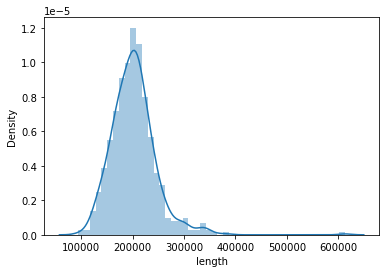

In [8]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]['length'])

print("The average length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]['length'].mean())) ))
print("The median length of a hit song with at least 50 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 50000000]), "songs earned over 50 mil streams during their time in the top 50 of Streaming since 2017")



The average length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:21:201644
The median length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200690
389 songs earned over 100 mil streams during their time in the top 50 of Streaming since 2017


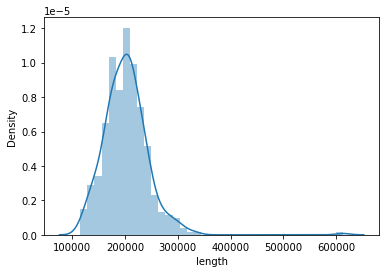

In [9]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]['length'])

print("The average length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]['length'].mean())) ))
print("The median length of a hit song with at least 100 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 100000000]), "songs earned over 100 mil streams during their time in the top 50 of Streaming since 2017")


The average length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:18:198575
The median length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:16:196077
201 songs earned over 200 mil streams during their time in the top 50 of Streaming since 2017


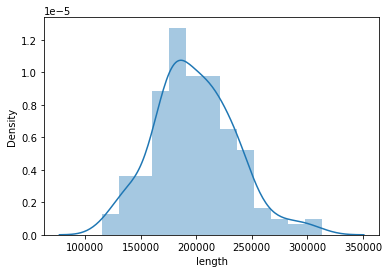

In [10]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]['length'])

print("The average length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]['length'].mean())) ))
print("The median length of a hit song with at least 200 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 200000000]), "songs earned over 200 mil streams during their time in the top 50 of Streaming since 2017")


The average length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200720
The median length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200547
117 songs earned over 300 mil streams during their time in the top 50 of Streaming since 2017


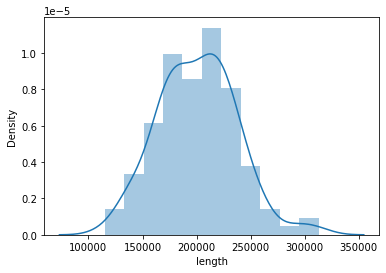

In [11]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]['length'])

print("The average length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]['length'].mean())) ))
print("The median length of a hit song with at least 300 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 300000000]), "songs earned over 300 mil streams during their time in the top 50 of Streaming since 2017")



The average length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:15:195759
The median length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:15:195428
61 songs earned over 400 mil streams during their time in the top 50 of Streaming since 2017


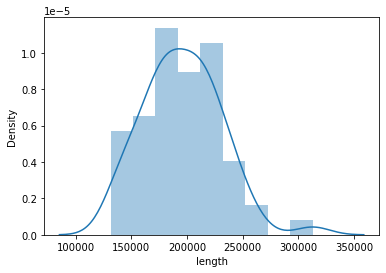

In [12]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]['length'])

print("The average length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]['length'].mean())) ))
print("The median length of a hit song with at least 400 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 400000000]), "songs earned over 400 mil streams during their time in the top 50 of Streaming since 2017")


The average length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:18:198313
The median length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:19:199506
38 songs earned over 500 mil streams during their time in the top 50 of Streaming since 2017


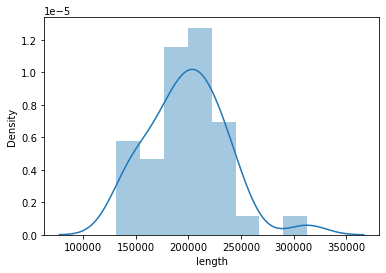

In [13]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]['length'])

print("The average length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]['length'].mean())) ))
print("The median length of a hit song with at least 500 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 500000000]), "songs earned over 500 mil streams during their time in the top 50 of Streaming since 2017")



The average length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:24:204580
The median length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is:  03:20:200040
17 songs earned over 600 mil streams during their time in the top 50 of Streaming since 2017


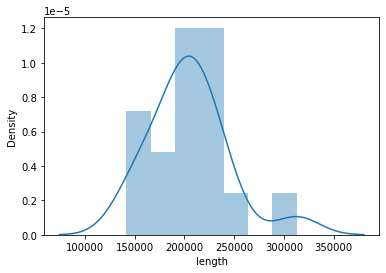

In [14]:
sns.distplot(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]['length'])

print("The average length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]['length'].mean())) ))
print("The median length of a hit song with at least 600 mil streams during their time on the Streaming Top 50 (excluding holiday music) is: ", 
      ms_to_time( int(round(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]['length'].median())) ))
print(len(gsheets_df_updated[gsheets_df_updated['streams_2017_to_present'] > 600000000]), "songs earned over 600 mil streams during their time in the top 50 of Streaming since 2017")



# Biggest songs of the on-demand audio streaming era!
__Congrats to the following songs for having the most impact on the top 50!!! 🥳🥳__

In [15]:
gsheets_df_updated.groupby(['title','album','artist','peak_date']).sum().sort_values('streams_2017_to_present',ascending=False).head(50).loc[:,['streams_2017_to_present']].reset_index()


,title,album,artist,peak_date,streams_2017_to_present
0,Sunflower - Spider-Man: Into the Spider-Verse,Hollywood's Bleeding,Post Malone,2019-01-11,1286716702
1,Blinding Lights,After Hours,The Weeknd,2020-03-20,1129497524
2,Old Town Road - Remix,7 EP,Lil Nas X,2019-04-05,977389701
3,Heat Waves,Dreamland (+ Bonus Levels),Glass Animals,2021-09-10,931802902
4,The Box,Please Excuse Me for Being Antisocial,Roddy Ricch,2020-01-17,890033461
5,God's Plan,Scorpion,Drake,2018-01-19,825137204
6,Levitating,Future Nostalgia (The Moonlight Edition),Dua Lipa,2021-05-14,812882719
7,rockstar (feat. 21 Savage),beerbongs & bentleys,Post Malone,2017-09-22,800752849
8,Save Your Tears,After Hours,The Weeknd,2021-04-23,749759436
9,ROCKSTAR (feat. Roddy Ricch),BLAME IT ON BABY (DELUXE),DaBaby,2020-06-12,744336312


# Biggest songs of the 2020s so far!
__Songs that are shaping up to the the largest of this decade so far__

In [16]:
gsheets_df_updated.groupby(['title','album','artist','peak_date']).sum().sort_values('total_streams_2020s',ascending=False).head(50).loc[:,['total_streams_2020s']].reset_index()


,title,album,artist,peak_date,total_streams_2020s
0,Blinding Lights,After Hours,The Weeknd,2020-03-20,1100314961
1,Heat Waves,Dreamland (+ Bonus Levels),Glass Animals,2021-09-10,931802902
2,The Box,Please Excuse Me for Being Antisocial,Roddy Ricch,2020-01-17,873181216
3,Levitating,Future Nostalgia (The Moonlight Edition),Dua Lipa,2021-05-14,812882719
4,Save Your Tears,After Hours,The Weeknd,2021-04-23,749759436
5,ROCKSTAR (feat. Roddy Ricch),BLAME IT ON BABY (DELUXE),DaBaby,2020-06-12,744336312
6,"Whats Poppin (feat. DaBaby, Tory Lanez & Lil W...",Thats What They All Say,Jack Harlow,2020-06-26,738896697
7,STAY (with Justin Bieber),F*CK LOVE 3+: OVER YOU,The Kid LAROI,2021-07-09,734364385
8,good 4 u,SOUR,Olivia Rodrigo,2021-05-21,668370094
9,Life Is Good (feat. Drake),High Off Life,Future,2020-01-10,575997848


# Strongest song peaks!
__Most dominant songs in any given week (this is precisely why weekly chart ranks shouldn't matter)__

In [17]:
gsheets_df_updated.groupby(['title','album','artist','peak_date']).sum().sort_values('peak_week_streams',ascending=False).head(50).loc[:,['peak_week_streams']].reset_index()


,title,album,artist,peak_date,peak_week_streams
0,Old Town Road - Remix,7 EP,Lil Nas X,2019-04-05,83196801
1,God's Plan,Scorpion,Drake,2018-01-19,73364601
2,In My Feelings,Scorpion,Drake,2018-07-06,62955923
3,drivers license,SOUR,Olivia Rodrigo,2021-01-08,61987428
4,Nonstop,Scorpion,Drake,2018-06-29,58506448
5,Rich Flex,Her Loss,Drake,2022-11-04,58141838
6,good 4 u,SOUR,Olivia Rodrigo,2021-05-21,57706721
7,The Box,Please Excuse Me for Being Antisocial,Roddy Ricch,2020-01-17,57151149
8,Way 2 Sexy (with Future & Young Thug),Certified Lover Boy,Drake,2021-09-03,56170489
9,WAP (feat. Megan Thee Stallion),WAP (feat. Megan Thee Stallion),Cardi B,2020-08-07,55334997


# Biggest album eras of the on-demand audio streaming era!
__Congrats to the following albums for having the most impact on the top 50!!! 🥳🥳__

In [18]:
gsheets_df_updated.groupby(['album','artist']).sum().sort_values('streams_2017_to_present',ascending=False).head(40).loc[:,['streams_2017_to_present']].reset_index()



,album,artist,streams_2017_to_present
0,Hollywood's Bleeding,Post Malone,3529505496
1,Scorpion,Drake,3438508643
2,beerbongs & bentleys,Post Malone,2881289563
3,Un Verano Sin Ti,Bad Bunny,2318619931
4,SOUR,Olivia Rodrigo,2314943123
5,After Hours,The Weeknd,2243048221
6,Certified Lover Boy,Drake,1872071124
7,Shoot For The Stars Aim For The Moon,Pop Smoke,1720816058
8,DAMN.,Kendrick Lamar,1610093270
9,ASTROWORLD,Travis Scott,1607102124


# Biggest artists of the on-demand audio streaming era!
__Congrats to the following artists for having the most impact on the top 50 and for being streaming monsters!!! 🥳🥳🫡__

In [19]:
gsheets_df_updated.groupby(['artist']).sum().sort_values('streams_2017_to_present',ascending=False).head(40).loc[:,['streams_2017_to_present']].reset_index()


,artist,streams_2017_to_present
0,Drake,9204949315
1,Post Malone,7700359789
2,Lil Baby,3780605842
3,Bad Bunny,3115182746
4,Juice WRLD,3085333613
5,The Weeknd,3036571936
6,Taylor Swift,3029340082
7,Ariana Grande,2794145950
8,Lil Nas X,2658461979
9,Cardi B,2583215792


# Creating a Dashboard of week-to-week changes in song characteristics
Before creating a dashboard, the dataframe must be "melted" (all weekly streams must be condensed into one column). Furthermore, variables (such as tempos and song lengths) must be normalized.

In [20]:
#create a list of dates
list_of_dates = gsheets_df_updated.columns.to_list()[8:-27]

#melt the data (converting the dataframe's info on song streams from horizontal to vertical form)
df_melted = gsheets_df_updated.melt(id_vars=['title','artist','album','peak_date'],
        value_vars=list_of_dates, var_name='observed_date', value_name='streams')
df_melted.drop(df_melted[df_melted['streams']==0].index, inplace=True) #drop all weekly observations with 0 streams
df_melted.reset_index(drop=True, inplace=True)

#convert the observed_date to a datetime format
df_melted['observed_date'] = pd.to_datetime(df_melted['observed_date'])

#drop data from the weeks starting on 2019-12-13 and 2019-12-20
#there's very few data on those weeks (these few songs were individually-calculated using Rolling Stones charts as reference)
df_melted.drop(df_melted[ (df_melted['observed_date']=='2019-12-13') | (df_melted['observed_date']=='2019-12-20') ].index, inplace=True)

#create variables for each song observation's year, month and week 
df_melted['obs_year'] = df_melted['observed_date'].apply(lambda x: x.year)
df_melted['obs_month'] = df_melted['observed_date'].apply(lambda x: x.month)
df_melted['obs_week'] = df_melted['observed_date'].apply(lambda x: x.isocalendar()[1])

#get variables to merge w/ df_melted (since every value after the weekly streams were eliminated in the melting process)
to_merge = ['title','artist','album','length','acousticness','danceability','energy',
 'instrumentalness','key','liveness','loudness','mode','speechiness','tempo',
 'time_signature','valence','explicit']

#merge
df_melted = pd.merge(df_melted, gsheets_df_updated.loc[:,to_merge], how='left', on=['title','artist','album'])

#add normalized tempos (scale them to graph with other variables)
df_melted['tempo_normalized'] = df_melted['tempo'] / df_melted['tempo'].max()

#add normalized lengths (scale them to graph with other variables)
df_melted['length_normalized'] = df_melted['length'] / df_melted['length'].max()

df_melted

,title,artist,album,peak_date,observed_date,streams,obs_year,obs_month,obs_week,length,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,explicit,tempo_normalized,length_normalized
0,As It Was,Harry Styles,Harry's House,2022-04-01,2022-11-18,9188099,2022,11,46,167303.0,0.3420,0.520,0.731,0.001010,6.0,0.3110,-5.338,0.0,0.0557,173.930,4.0,0.662,False,0.838314,0.272913
1,Something in the Orange,Zach Bryan,Something in the Orange,2022-10-14,2022-11-18,13045498,2022,11,46,228013.0,0.5550,0.369,0.192,0.000008,4.0,0.0954,-12.151,0.0,0.0400,175.212,3.0,0.148,False,0.844493,0.371947
2,WAIT FOR U (feat. Drake & Tems),Future,I NEVER LIKED YOU,2022-04-29,2022-11-18,7948985,2022,11,46,189893.0,0.3140,0.463,0.642,0.000000,1.0,0.0686,-4.474,1.0,0.3400,83.389,4.0,0.339,True,0.401921,0.309763
3,Tití Me Preguntó,Bad Bunny,Un Verano Sin Ti,2022-05-06,2022-11-18,9314363,2022,11,46,243716.0,0.0993,0.650,0.715,0.000291,5.0,0.1260,-5.198,0.0,0.2530,106.672,4.0,0.187,False,0.514141,0.397562
4,Me Porto Bonito,Bad Bunny,Un Verano Sin Ti,2022-05-06,2022-11-18,8193238,2022,11,46,178567.0,0.0901,0.911,0.712,0.000027,1.0,0.0933,-5.105,0.0,0.0817,92.005,4.0,0.425,True,0.443449,0.291288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13951,Everybody,Logic,Everybody,2017-05-05,2017-03-31,6840444,2017,3,13,162346.0,0.1610,0.885,0.940,0.000000,1.0,0.0675,-5.908,1.0,0.0913,110.005,4.0,0.773,True,0.530206,0.264827
13952,Slide (feat. Frank Ocean & Migos),Calvin Harris,Funk Wav Bounces Vol.1,2017-06-30,2017-03-31,8370887,2017,3,13,230813.0,0.4980,0.736,0.795,0.000001,1.0,0.2540,-3.299,0.0,0.0545,104.066,4.0,0.511,True,0.501581,0.376514
13953,goosebumps,Travis Scott,Birds In The Trap Sing McKnight,2017-05-12,2017-03-31,6199013,2017,3,13,243836.0,0.0847,0.841,0.728,0.000000,7.0,0.1490,-3.370,1.0,0.0484,130.049,4.0,0.430,True,0.626815,0.397758
13954,Body Like A Back Road,Sam Hunt,SOUTHSIDE,2017-06-30,2017-03-31,6933658,2017,3,13,162546.0,0.4410,0.736,0.458,0.000000,5.0,0.1480,-7.437,1.0,0.0316,98.977,4.0,0.650,False,0.477053,0.265154


In [21]:
### group data by week with mean data
df_grpd_meltd_mean = df_melted.groupby(['observed_date']).mean().reset_index()

#plot the following variables
to_plot = ['observed_date','danceability','energy','acousticness','instrumentalness',
          'speechiness','tempo_normalized','length_normalized','valence']

#plot the graph
fig = px.line(df_grpd_meltd_mean.loc[:,to_plot].set_index('observed_date'))
fig.show()



## **To view the graph above from GitHub, [click this link](https://nbviewer.org/github/jeremiasfv22/USA-Hits-Spotify-Data-Project/blob/main/2%29%20Data%20Analysis%20-%20US%20Streaming%20Hits.ipynb)**

The following graph above provides interesting insights on the state of popular music in the United States throughout the on-demand audio streaming era (2017-present). Conclusions from the visual above are the following:

* ## __Danceability__
    - ___Definition___: _how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable._
    - __Discussion__: Danceability mostly remained above 0.7 from March 2017 to early 2021. Some notable exceptions include the following
        - May 17, 2019 - Release of both Tyler The Creator's [IGOR](https://open.spotify.com/album/5zi7WsKlIiUXv09tbGLKsE?si=SkxA3d3NTJGLRCHowGSd5A) and DJ Khaled's [Father of Asahd](https://open.spotify.com/album/1YgX8BWKleDlDeCOFklRfz?si=KbLhqAiOQ4iQsYJTFkwNEQ) 
        - Oct 25, 2019 - Kanye West's release of the gospel-inspired [JESUS IS KING](https://open.spotify.com/album/0FgZKfoU2Br5sHOfvZKTI9?si=40bxC04NT2KeC4BtT-YJww) 
        - Mar 20, 2020 - The Weeknd's release of his dramatic [After Hours](https://open.spotify.com/album/4yP0hdKOZPNshxUOjY0cZj?si=9NYEQOblR2u300KIxVTE0w) album
        - Jul 10, 2020 - Juice WRLD's release of his huge slow-paced posthumous album [Legends Never Die](https://open.spotify.com/album/6n9DKpOxwifT5hOXtgLZSL?si=qNtvXiKJT3aSJ5Auc2Ml8g) __RIP 999__
        - Jul 24, 2020 - Taylor Swift's release of [Folklore](https://open.spotify.com/album/2fenSS68JI1h4Fo296JfGr?si=b7RVGtn8Sqafj2D09O4TJg) an indie-folk record
        - Dec 11, 2020 - Taylor Swift's release of [Evermore](https://open.spotify.com/album/2Xoteh7uEpea4TohMxjtaq?si=Uw__bk1SQiye80hUSJRxPQ) a follow-up to Folklore
        - Jan 8, 2021 - Morgan Wallen's huge country album titled [Dangerous: The Double Album](https://open.spotify.com/album/6JlCkqkqobGirPsaleJpFr?si=XsRp8MjYQ-K5yoi7pCSnuA) released

    From early 2021 danceability for hit songs decreased to be below 0.7 (measured on a scale from 0.0-1.0). A few notable exceptions include:
        - Apr 29, 2022 - Future releases [I NEVER LIKED YOU](https://open.spotify.com/album/6tE9Dnp2zInFij4jKssysL?si=UB6k1H-2T7-hH0aFzvVpcQ)
        - May 6, 2022 - Bad Bunny releases the worldwide summer SMASH [Un Verano Sin Ti](https://open.spotify.com/album/3RQQmkQEvNCY4prGKE6oc5?si=6IYFPljWSP-t9jOLJJDY5Q)
        - May 26, 2022 - Harry Styles releases [Harry's House](https://open.spotify.com/album/5r36AJ6VOJtp00oxSkBZ5h?si=Gw-r3-VhTIy2Si8NZKK_6w) alongside many of Bad Bunny's recent album holding up on the charts
        
    Whether hit music increases its danceability depends on the upcoming weeks and months (and years) of popular music. __The decrease in danceability, according to Spotify's definition, since 2021 is likely due to the weakened influence of the late-2010s style of trap music__ (which was DOMINANT up until this time). Trap music is characterized by having rhythms that are typically great for parties (and head-bobbing). 


* ## __Energy__
    - ___Definition___: _a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy._
    - __Discussion__: Throughout 2017, energy levels generally increased! By the last week of the year/first week of 2018 (the week starting with Dec 27, 2017), a peak in energy was reached that wasn't surpassed until summer 2022. Some songs from that week that highly demonstrate this definition are the following:
        - [Plain Jane REMIX (feat. Nicki Minaj)](https://open.spotify.com/track/2YzmfPLqUx5CJOaw5ThsBV?si=2da12ed62eff4094) by ASAP FERG (a fast-paced energetic trap banger) 
        - [Thunder](https://open.spotify.com/track/1zB4vmk8tFRmM9UULNzbLB?si=05fe1f4cde9a44c4) by Imagine Dragons (a epic loud-sounding electropop/arena-rock song)
        - [Stir Fry](https://open.spotify.com/track/2UVbBKQOdFAekPTRsnkzcf?si=0034570fb1414ce9) by Migos (a playful fast-paced Pharrel-produced pop trap song)
        - [No Limit](https://open.spotify.com/track/2DQ1ITjI0YoLFzuADN1ZBW?si=0de83ec44d9648ee) by G-Eazy, ASAP Rocky and Cardi B (a fast paced trap banger with one of Cardi B's most fire verses ever)
        - [Unforgettable](https://open.spotify.com/track/3B54sVLJ402zGa6Xm4YGNe?si=d57b9f859cd040a8) by French Montana and Swae Lee (a club-ready Afrobeats/dancehall/hip-hop song)
        - [Wolves](https://open.spotify.com/track/0tBbt8CrmxbjRP0pueQkyU?si=1e840ee76f3640f4) by Marshmello and Selena Gomez (an trap-inspired EDM-pop song with a soaring vocals and an EDM-build-up in the chorus)
       
    However, throughout 2018 until mid-2019, energy levels would decrease. Albums that caused notable decreases in energy are the following:
        - Jun 27, 2018 - Drake's record-breaking [Scorpion](https://open.spotify.com/album/1ATL5GLyefJaxhQzSPVrLX?si=KXk2zncsTzO4h0TVVfLHYA) (with various slower-paced, moody songs particularly the latter half of the project)
        - Dec 7, 2018 - XXXTENTACION's posthumous [SKINS](https://open.spotify.com/album/1qsQOC4Jn0fnaUZLAbs4dz?si=vhthEfDOTsih-eDizfKuqg) (an mostly lo-fi hip-hop album, a genre known to be more "chiller" in sound)
        - Mar 29, 2019 - Billie Eilish's [WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?](https://open.spotify.com/album/0S0KGZnfBGSIssfF54WSJh?si=MypEuVRsTS2_AN4HZ7X8Ug) (an album featuring a lot of chill lofi-pop songs)
        
    The week of Billie Eilish's 2019 album is, in fact, the lowest peak for the average energy levels of any chart week since 2017. __This drop in energy from early-2018 to mid-2019 can be attributed to the acceptance of chiller, moody trap music/lofi music in the mainstream.__
    
    Since mid-2019, average energy levels hovered around 0.6. This trend would continue until 2022, when energy levels stayed almost consistently above 0.6 with an upwards trend throughout the summer. Energy levels peaked on Sept 2, 2022, a week where 45 out of 50 songs had energy levels at or above 0.5! Some summer songs that represent this trend include the following:
        - [I'm Good (Blue)](https://open.spotify.com/track/4uUG5RXrOk84mYEfFvj3cK?si=7188fc8bd7be4099) by David Guetta and Bebe Rexha (a HIGH energy EDM song, _the most energetic song to touch to top 50 since 2017_)
        - [She Had Me At Heads Carolina](https://open.spotify.com/track/200x8ONbPfFzByUr3fVz46?si=d626881dc3f546fd) by Cole Swindell (a fast-paced country song with a ready-to-play-with-windows-rolled-down feel)
        - [Después de la Playa](https://open.spotify.com/track/1dm6z1fWB0cErMszU25dy2?si=c57984e262ed4f68) by Bad Bunny (a song that starts off slow and then explodes into volcanic, lively Dominican merengue)
        - [BREAK MY SOUL](https://open.spotify.com/track/5pyoxDZ1PX0KxBxiRVxA4U?si=07671841da144bf7) by Beyoncé (a highly energetic ode-to-Queer-folks dance single off her latest album, Renaissance)
        - [Super Freaky Girl](https://open.spotify.com/track/2yjlYDiNiQkdxVqTlaSrlX?si=269455c8a6d84953) by Nicki Minaj (a lively uptempo pop rap song, popular on Tik Tok)
        - [Betty (Get Money)](https://open.spotify.com/track/1JCrXIeI6a9qRIkfAEz7J1?si=62e242040f764b36) by Yung Gravy (another uptempo song that dominated Tik Tok trends)
        - [Tarot](https://open.spotify.com/track/41oY4WCTj5kccfesTVFnvN?si=c31b86e004874576) by Bad Bunny (an uptempo EDM-reggaeton song)
        - [Talk](https://open.spotify.com/track/0oO1AbL92F6329z13C2qQH?si=92f24023abb6402e) by Yeat (a loud, bass heavy, highly electronic rager rap song)
        - [Tití Me Preguntó](https://open.spotify.com/track/1IHWl5LamUGEuP4ozKQSXZ?si=b647caeb83724ca5) by Bad Bunny (an uptempo Dominican-dembow-inspired reggaeton song with sections of psychadelic "trap")
        - [About Damn Time](https://open.spotify.com/track/6HMtHNpW6YPi1hrw9tgF8P?si=66ff7019e3764dc2) by Lizzo (a feel-good pop/funk/disco song that also dominated Tik Tok trends early in the summer)
        
     You should get the point by now! __Summer 2022 was the summer of energy across many genres!!__ This year was also the most musically diverse for streaming yet! Fall 2022 saw a dip in energy with the chart slaughter brough about by the following albums:
        - [It's Only Me](https://open.spotify.com/album/0FYvMdfTfYJxnJnKs1wDb0?si=dL8a-HlkR269nZ0X4QABfg) by Lil Baby (Oct 14, 2022)
        - [Midnights (3am Edition)](https://open.spotify.com/album/3lS1y25WAhcqJDATJK70Mq?si=tp1DdE15TgWW51lBIFqXYg) by Taylor Swift (Oct 21, 2022)
        - [Her Loss](https://open.spotify.com/album/5MS3MvWHJ3lOZPLiMxzOU6?si=Vnsk2jlnT7ubPXc7QC24rw) by Drake and 21 Savage (Nov 4, 2022)
        
     Other than these 3 huge albums (especially Drake and Taylor's albums), __the rise in energy in 2022 is likely due to pandemic restrictions lessening and people returning back to clubs/festivals/raves, increasing the demand for energetic music__. 
    
    
* ## __Tempo__
    - ___Definition___: _The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. In the graph above, tempos are normalized to fit on a scale between 0 to 1._
    - __Discussion__: Tempo mostly remains the same throughout the years. Not so much variation there. It would be interesting to include data on hit music going back to 2009/2010 which marks the start of the high-tempo club-pop music popular in the early 2010s. It is expected for tempo to drop as the years go by if we start analyzing from 2009/2010. 


* ## __Valence__
    - ___Definition___: _A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)._
    - __Discussion__: After a brief rise in positive-sounding music, the couple of years after July 2017 were marked by consistent low points in positive-sounding music. __Summer of 2018 proved to be especially strong for music that does not possess musical positiveness__. Several major events that occured at this time include:
        - The __unfortunate passing of XXXTENTACION__ (undisputedly, a leader in the emo-rap/soundcloud rap movement) and [his songs](https://open.spotify.com/album/5VdyJkLe3yvOs0l4xXbWp0?si=XvmDCF4hRhGHG68PNZrBgQ) subsequentially [flooding the chart](https://open.spotify.com/album/2Ti79nwTsont5ZHfdxIzAm?si=ZwVkLV7SQjqdqzRGzC4oEg), 
        - __[Drake's Scorpion](https://open.spotify.com/album/1ATL5GLyefJaxhQzSPVrLX?si=kTO5GoaHQZWOEUA5-0pY3w) demolishing the charts__
        - __The charts reflecting an overall moody/darker version of trap music__. The following songs are examples of songs that scored very low on valence, taken from the peaks of sad/angry-sounding music on the weeks of July 13, 2018 and Sept 7, 2018:
            - [Jaded](https://open.spotify.com/track/4c2xt1trwYZpMqPWY35Xi9?si=ba4896d7a7fb4064) by Drake
            - [Elevate](https://open.spotify.com/track/3szf2z1Cy1QMrtHrbn8rz9?si=2d089514fb0b474a) by Drake
            - [STARGAZING](https://open.spotify.com/track/7wBJfHzpfI3032CSD7CE2m?si=8672d231a62b478b) by Travis Scott
            - [rockstar](https://open.spotify.com/track/0e7ipj03S05BNilyu5bRzt?si=853e7faaebc64eaf) by Post Malone & 21 Savage
            - [Lucid Dreams](https://open.spotify.com/track/285pBltuF7vW8TeWk8hdRR?si=efd2c806618a44ec) by Juice WRLD
            - [All Girls Are The Same](https://open.spotify.com/track/4VXIryQMWpIdGgYR4TrjT1?si=067284fdf2ca4110) by Juice WRLD
            - [Come Back To Earth](https://open.spotify.com/track/01z2fBGB8Hl3Jd3zXe4IXR?si=416d36fd7bda45c8) by Mac Miller
            - [YOSEMITE](https://open.spotify.com/track/7lAK3oHbfEnvUQWosrMMpR?si=a001e4100b394ad0) by Travis Scott
            - [Fuck Love](https://open.spotify.com/track/7AQim7LbvFVZJE3O8TYgf2?si=96b16b9a9c6e4fcd) by XXXTENTACION & Trippie Redd
            - [All Mine](https://open.spotify.com/track/3U21A07gAloCc4P7J8rxcn?si=ef4b3211dbbe41e1) by Kanye West
            - [Don't Matter To Me](https://open.spotify.com/track/6G8kHiVZ1jW7vHMPVRNZU0?si=9ae104b7fad04176) by Drake and Michael Jackson

    __Cheerful/uptempo pop music was also commercially at its weakest during 2018/early 2019. Almost all commercially successful songs made by pop artists, like Ariana Grande, were either trap-infused or inspired by trap/Soundcloud Rap and, most importantly, succumbed to the pressures of sounding dark/moody/non-happy.__ Several examples of songs by pop artists from this era that exemplify these traits are the following:
        - [God Is A Woman](https://open.spotify.com/track/5OCJzvD7sykQEKHH7qAC3C?si=19c27b93f8b14391) by Ariana Grande
        - [7 Rings](https://open.spotify.com/track/6ocbgoVGwYJhOv1GgI9NsF?si=286aa0b9400f4502) by Ariana Grande
        - [Shallow](https://open.spotify.com/track/2VxeLyX666F8uXCJ0dZF8B?si=1cf611bb7cc246f0) by Lady Gaga and Bradley Cooper
        - [when the party's over](https://open.spotify.com/track/43zdsphuZLzwA9k4DJhU0I?si=1f15ac890ac04dab) by Billie Eilish
        - [bury a friend](https://open.spotify.com/track/4SSnFejRGlZikf02HLewEF?si=422094a8de3d4046) by Billie Eilish
        - [Eastside](https://open.spotify.com/track/7FGq80cy8juXBCD2nrqdWU?si=9c6d8aaaca754ff6) by benny blanco, Khalid & Halsey
        - [lovely](https://open.spotify.com/track/0u2P5u6lvoDfwTYjAADbn4?si=8f13988ca6bf41b2) by Billie Eilish & Khalid
        - [FAKE LOVE](https://open.spotify.com/track/6m1TWFMeon7ai9XLOzdbiR?si=12975c7a9d6b4fa7) by BTS
        - [break up with your girlfriend, i'm bored](https://open.spotify.com/track/4kV4N9D1iKVxx1KLvtTpjS?si=7f0f2751ac5a40dc) by Ariana Grande
        - [you should see me in a crown](https://open.spotify.com/track/3XF5xLJHOQQRbWya6hBp7d?si=e3b821d55b9f4bbe) by Billie Eilish
        - [xanny](https://open.spotify.com/track/4QIo4oxwzzafcBWkKjDpXY?si=184c80d62bad49ac) by Billie Eilish
        
    Once happiness levels hit 0.5 for the first time in two years in June 28, 2019, valence levels mostly hovered at a range of about 0.40 to 0.55. Interestingly, __peak valence levels occured early on during the pandemic lockdowns__ on April 10, 2020. This is __likely due to the fact that people wanted to escape during the sad/lonely/uncertain times from the start of the pandemic__. Some songs happier-sounding/cheerful-sounding songs popular this week include:
        - [Sunflower](https://open.spotify.com/track/0RiRZpuVRbi7oqRdSMwhQY?si=e8c5007ecde8420a) by Post Malone and Swae Lee (peaked more than a year before April 2020, but lasted on the charts forever)
        - [Intentions](https://open.spotify.com/track/4umIPjkehX1r7uhmGvXiSV?si=3a2cc1beaa9f4a3d) by Justin Bieber feat. Quavo
        - [Roses - Imanbek Remix](https://open.spotify.com/track/0zLCBJZSiELJf02ucPP9wb?si=6604c3b710f544ff) by SAINt JHN
        - [BOP](https://open.spotify.com/track/6Ozh9Ok6h4Oi1wUSLtBseN?si=16de1fb039e241ce) by DaBaby
        - [Godzilla](https://open.spotify.com/track/7FIWs0pqAYbP91WWM0vlTQ?si=844a46bc22b344d5) by Eminem & Juice WRLD
        - [Whats Poppin](https://open.spotify.com/track/0ZLuW8uOXdFNWcI40C0OC2?si=3d9f7bbbebcb463d) by Jack Harlow
        - [Level of Concern](https://open.spotify.com/track/6xZ4Q2k2ompmDppyeESIY8?si=4d84dd708c7640c8) by Twenty One Pilots
        - [Supalonely](https://open.spotify.com/track/4nK5YrxbMGZstTLbvj6Gxw?si=f124d6c554f1423c) by BENEE
        - [Don't Start Now](https://open.spotify.com/track/2FlcxnvybdwpaMmMhaRtSN?si=14f53bcb36694771) by Dua Lipa
        - [Say So](https://open.spotify.com/track/3Dv1eDb0MEgF93GpLXlucZ?si=0983d4b5e6474316) by Doja Cat
        
    Also interesting to note, the __lowest levels of valence ever comes from Nov 4, 2022, when [Drake's Her Loss](https://open.spotify.com/album/5MS3MvWHJ3lOZPLiMxzOU6?si=ZZVnN3F-T5GxtfzAdK7ejg) and [Taylor Swift's Midnights (3am Edition)](https://open.spotify.com/album/3lS1y25WAhcqJDATJK70Mq?si=RqEbsHJBRIGG0HH_J4heow) took up a whopping 72% of the top 50.__
    

* ## __Length__
    - ___Definition___: _The duration of the track, measured by Spotify in milliseconds. In the graph above, song lengths are normalized to fit on a scale between 0 to 1._
    - __Discussion__: The average __length__ of hit songs in the late 2010s gradually decreased (a pattern noticed by many other researchers). However, ___unlike the conclusions made in most prior research which does not include data on the 2020s, it is clear that there is a slow increase in the average length of hit songs since late 2019 up until the early 2020s___. Some weeks in the 2020s with higher-than-normal levels of average song lengths the following:
        - Mar 20, 2020 - The release of [After Hours](https://open.spotify.com/album/4yP0hdKOZPNshxUOjY0cZj?si=0c_1NrGqS3q1z_9ZcHfgcw) by The Weeknd (average song length of 4 minutes 1 seconds)
        - Jul 24, 2020 - The release of [Folkore](https://open.spotify.com/album/2fenSS68JI1h4Fo296JfGr?si=62z-_L_VSSqZm9YReHvJwA) by Taylor Swift (average song length of 3 mins 58 seconds)
        - Dec 12, 2020 - The release of [Evermore](https://open.spotify.com/album/2Xoteh7uEpea4TohMxjtaq?si=zCce0-haTVOwvJdPGz2kig) by Taylor Swift (average song length of 3 minutes 49 seconds)
        - Aug 28, 2021 - The release of [Donda](https://open.spotify.com/album/5CnpZV3q5BcESefcB3WJmz?si=HDXFikcLTliTLfu8-mV00Q) by Kanye West (average song length 3 minutes 49 seconds)
        - Sept 3, 2021 - The release of [Certified Lover Boy](https://open.spotify.com/album/3SpBlxme9WbeQdI9kx7KAV?si=1Fh5rYqLScmbHExbf8PxvQ), a __record breaking album__ from Drake (average song length of 4 minutes 6 seconds)
        - Nov 12, 2021 - The release of [Red (Taylor's Version)](https://open.spotify.com/album/6kZ42qRrzov54LcAk4onW9?si=RjaM2H7mTquKafkriTDL2A) by Taylor Swift (average song length of 4 minutes 18 seconds)
            - This album also features __the longest song in the dataset, the [10 minute version of All Too Well](https://open.spotify.com/track/5enxwA8aAbwZbf5qCHORXi?si=2893cf54f92b43f6))__
        - Nov 19, 2021 - The release of [30](https://open.spotify.com/album/21jF5jlMtzo94wbxmJ18aa?si=_iYQiyeUToyDgz4oChUkKQ) by Adele (average song length of 4 minutes 51 seconds)
            - Within the dataset, ___30_ is the album with the LARGEST average song length__
        - May 13, 2022 - The release of [Mr. Morale & The Big Steppers](https://open.spotify.com/album/79ONNoS4M9tfIA1mYLBYVX?si=OKfhkhsfRI-_ou2Sh6UV6w) by Kendrick Lamar (average song length of 4 minutes 8 seconds)
        
    Interestingly, __these albums are all made by industry veterans__, artists that already have several major hits under their belt and __can afford to release albums with longer-than-normal songs while still finding massive amounts of success__. However, many of __their newer counterparts, make albums with shorter-than-average__ (average being 3 minutes 20 seconds) __song lengths__. Several examples of debut albums made by new artists in the 2020s and the average song lengths of their album's songs are the following:
        - [Shoot For The Stars, Aim For The Moon](https://open.spotify.com/album/7e7t0MCrNDcJZsPwUKjmOc?si=u9Bos6usQe6TkvUR28I_6w) by Pop Smoke (average song length of 2 minutes 59 seconds, Jul 3, 2020) __RIP Pop Smoke__
        - [SOUR](https://open.spotify.com/album/6s84u2TUpR3wdUv4NgKA2j?si=STnKbWoERiO4v9TPF6UfQg) by Olivia Rodrigo (average song length of 3 minutes 9 seconds, May 21, 2021)
        - [MONTERO](https://open.spotify.com/album/6pOiDiuDQqrmo5DbG0ZubR?si=JufJa4TnR2iKcm5cUvYRaw) by Lil Nas X (average charting song length of 2 minutes 48 seconds, Sept 21, 2021) 


* ## __Acoustiness__
    - ___Definition___: _A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic._
    - __Discussion__: __Acoustiness levels for hit songs hit a low point in 2018 (a year where rap/trap music firmly dominated the charts)__. However, there seems to be __a steady increase since its low point in early 2018__. Some albums that dramatically changed the acousticness levels of the top 50 the week they were released include the following: 
        - Dec 11, 2018 - [SKINS](https://open.spotify.com/album/1qsQOC4Jn0fnaUZLAbs4dz?si=S8LedNkJQZyauTNNku4dZQ) by XXXTENTACION (6 out 9 songs had acousticness levels above 0.5)
        - Mar 29, 2019 - [WHEN WE ALL FALL ASLEEP WHERE DO WE GO](https://open.spotify.com/album/0S0KGZnfBGSIssfF54WSJh?si=fopRhc_FS6S60jabHehvvQ) by Billie Eilish (8 out of 13 songs had acousticness levels above 0.5)
        - Jul 24, 2020 - [Folklore](https://open.spotify.com/album/2fenSS68JI1h4Fo296JfGr?si=3do5coOUQ4qQl27qwyh6Dg) by Taylor Swift (14 out of 16 songs had acousticness levels above 0.5)
        - Dec 11, 2020 - [Evermore](https://open.spotify.com/album/2Xoteh7uEpea4TohMxjtaq?si=2cW1k6gRQW6PB5NvNRVGgg) by Taylor Swift (11 out of 12 songs had acousticness levels above 0.5)
        - May 13, 2022 - [Mr. Morale and The Big Steppers](https://open.spotify.com/album/79ONNoS4M9tfIA1mYLBYVX?si=TAuehWLoRWSJxoFqnsG5Ug) by Kendrick Lamar (7 out of 18 songs had acoustincess levels above 0.5)
        
* ## __Speechiness__
    - ___Definition___: _Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks._
    - __Discussion__: __Speechiness levels mostly remained above 0.15 from spring 2018 to spring 2020 (to no coincidence, an era where rap music heavily dominated the charts)__. __Since the COVID-19 lockdowns of March 2020 started, there are noticeably more weeks where speechiness levels remain below 0.15.__ This also coincides with the increasing popularity of non-rap pop music on the streaming charts of the USA (___likely thanks to TikTok become the main platform for music discovery as opposed to SoundCloud which is more associated with rap___).

* ## __Instrumentalness__
    - ___Definition___: _Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0._
    - __Discussion__: Instrumentalness mostly remains low with some weeks of increase (as usual, coinciding with the releases of certain albums such as XXXTentacion's 2018 album, _[SKINS](https://open.spotify.com/album/1qsQOC4Jn0fnaUZLAbs4dz?si=xh-OLP2TTWGtgQTVAVWGrQ)_; Metro Boomin & 21 Savage's 2020 album, _[SAVAGE MODE 2](https://open.spotify.com/album/6wTyGUWGCilBFZ837k5aRi?si=qJWcKCZHSyWMaSpkZIceMg)_; and most recently, Drake's 2022 dance album, _[Honestly, Nevermind](https://open.spotify.com/album/3cf4iSSKd8ffTncbtKljXw?si=4H6du91HT1yyNhzMO2-_vQ)_. For the most part, highly instrumental tracks just aren't popular with the general public on streaming. Surprisingly, there was no increase in instrumentalness with Beyonce's dance-inspired album _[Renaissance](https://open.spotify.com/album/6FJxoadUE4JNVwWHghBwnb?si=koWA1quDTg66qR-MKrFyHw)_ released on July 29, 2022 (probably because it was more vocal than instrumental). However, there seems to be an small increase in instrumentalness throughout fall 2022!

This concludes the analysis portion of this project! The next part of this project clusters the songs together to see what types of songs make it to the top 50 of streaming in the USA!